<h1 style="font-size:32px; text-align:center;">Projet Scoring</h1>
<hr>
<h1 style="font-size:18px; text-align:center; margin-bottom:24px;">Ousmane KA</h1>
<hr>

In [1]:
import os
from pathlib import Path

# Ignorer les avertissements dans le code
import warnings
warnings.filterwarnings('ignore')

# Déterminer le nombre de cœurs disponibles
import multiprocessing
cores = multiprocessing.cpu_count()

# Définir le paramètre n_jobs pour GridSearchCV en fonction des cœurs disponibles
n_jobs = cores

# Bibliothèques générales
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Typage des fonctions et des variables
from typing import Callable, List, Optional, Tuple, Union

# Analyse exploratoire des données (EDA)
from scipy.optimize import curve_fit
from scipy.stats import chi2_contingency, mannwhitneyu
from scipy.stats.contingency import association
from sklearn.decomposition import PCA

# Prétraitement des données
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer

# Séparation des données et sélection des hyperparamètres
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

# Modèles de Machine Learning
from sklearn import tree, ensemble, linear_model

# Gestion des déséquilibres de classes
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Évaluation des performances des modèles
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# Interprétation des modèles avec SHAP
import shap
shap.initjs()

# Afficher plus de colonnes dans les DataFrames pandas
pd.set_option('display.max_columns', 30)


In [2]:
# Read the data set
df = pd.read_csv('./Dataset/hmeq_clean_miticulous.csv')


<span style="color:#0A8791; font-size:24px;"><b><u>Comparaison des résultats des différents modèles (avec une approche assez différente de celles éffectuées)</u></b></span>

STRICTEMENT NUMÉRIQUE
- LOAN (Prêt)
- MORTDUE (Dette hypothécaire)
- VALUE (Valeur du bien)
- YOJ (Années d'ancienneté dans l'emploi)
- CLAGE (Âge du crédit en mois)
- DEBTINC (Ratio dette/revenu)

STRICTEMENT ORDINAL
- DEROG (Nombre d’incidents graves sur le crédit)
- DELINQ (Nombre de paiements en retard)
- NINQ (Nombre de nouvelles demandes de crédit)
- CLNO (Nombre total de lignes de crédit)

STRICTEMENT NOMINAL
- REASON (Raison du prêt)
- JOB (Type d’emploi)

L'encodage du jeu de données peut être amélioré de la manière suivante :

- LOAN est actuellement un entier, mais il représente une valeur réelle. Il doit donc être converti en float.
- DEROG, DELINQ, NINQ, CLNO sont des variables catégorielles ordinales, mais elles sont encodées en float. Elles devraient être traitées comme des variables ordinales.
- CLNO a une large plage de valeurs (1-316) et pourrait être considérée comme une variable continue. Cependant, nous continuerons à l'utiliser comme une variable ordinale.
- YOJ pourrait être une variable ordinale, mais certaines valeurs comportent des fractions. Nous la considérerons donc comme une variable numérique.

In [3]:
# Convertir la colonne LOAN au type de données approprié
df['LOAN'] = df['LOAN'].astype(float)

In [4]:
# Définition de la variable cible
target_feature = 'BAD'

### Statistiques récapitulatives

In [5]:
# Création d'un DataFrame pour analyser la répartition des classes de la variable cible
class_weights = pd.DataFrame(df[target_feature].value_counts())

# Renommer la colonne si nécessaire pour garantir une meilleure lisibilité
if not 'count' in class_weights.columns:
    class_weights.rename(columns={target_feature: 'count'}, inplace=True)

# Calculer le pourcentage de chaque classe par rapport au total
class_weights['percentage'] = class_weights['count'] / class_weights['count'].sum()

# Afficher le tableau des statistiques
class_weights

,count,percentage
BAD,,
0,4750,0.803179
1,1164,0.196821


In [6]:
nominal_features = df.select_dtypes(include=['object']).columns
nominal_features = nominal_features.to_list()

In [7]:
# Définition des variables ordinales
ordinal_features = ['DEROG', 'DELINQ', 'NINQ', 'CLNO']

# Calcul des statistiques descriptives pour les variables ordinales
sum_stats = df[ordinal_features].describe()

# Sélection des statistiques pertinentes et formatage des valeurs sans décimales
sum_stats = sum_stats.loc[['count', 'min', '25%', '50%', '75%', 'max'], :].applymap(lambda x: f"{x:.0f}")


In [8]:
cat_features = nominal_features + ordinal_features

In [9]:
# Vérification de cohérence des variables numériques

# Sélectionner les colonnes de type numérique (entiers et flottants)
num_features = df.select_dtypes(include=['int64', 'float64']).columns

# Convertir en liste
num_features = num_features.to_list()

# Supprimer les variables catégoriques pour ne garder que les variables numériques
num_features = list(set(num_features) - set(cat_features))

# Retirer la variable cible de la liste des variables numériques
num_features.remove(target_feature)

# Afficher un résumé statistique des variables numériques
df[num_features].describe().T


,count,mean,std,min,25%,50%,75%,max
YOJ,5914.0,8.952150,7.403525,0.000000,3.000000,7.000000,13.000000,36.000000
LOAN,5914.0,18532.144065,11094.648073,1100.000000,11000.000000,16300.000000,23300.000000,89800.000000
CLAGE,5914.0,177.965391,78.526711,0.000000,116.801941,173.311907,228.372255,485.945358
MORTDUE,5914.0,71132.882313,43797.001752,2063.000000,43744.250000,62641.500000,88982.250000,399550.000000
VALUE,5914.0,102241.322793,54768.724042,8796.000000,66286.000000,89425.500000,121283.750000,512650.000000
DEBTINC,5914.0,33.574654,6.638266,0.524499,30.786408,33.829119,37.982496,69.800525


# **Analyse Exploratoire des Données (EDA) et Visualisation**


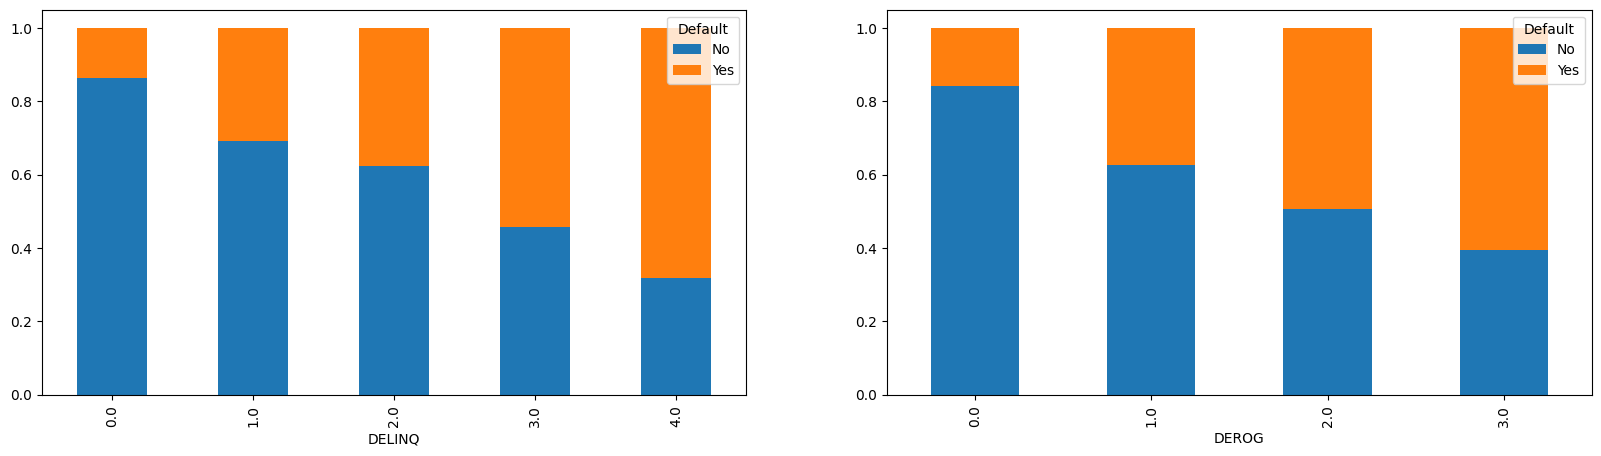

In [10]:
# Proportion de DELINQ = 0 pour BAD = 0 et BAD = 1
fig, axs = plt.subplots(1, 2, figsize=(20,5))
df.groupby('DELINQ')['BAD'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=axs[0])
axs[0].legend(title='Default', loc='upper right', labels=['No', 'Yes'])
df.groupby('DEROG')['BAD'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=axs[1])
axs[1].legend(title='Default', loc='upper right', labels=['No', 'Yes']);


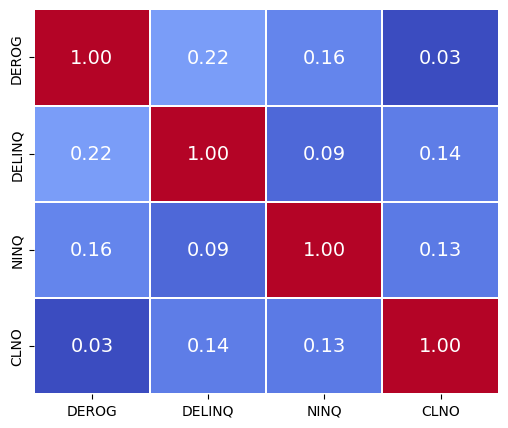

In [11]:
plt.figure(figsize=(6, 5))
sns.heatmap(df[ordinal_features].corr(method='spearman'), annot=True, cmap='coolwarm', cbar=False, fmt='.2f', linewidths=0.2, annot_kws={'size': 14});

#### Corrélation entre les variables numériques


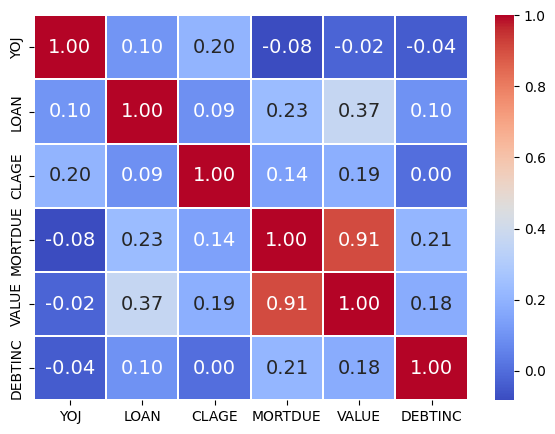

In [12]:
# Affichage de la matrice de corrélation
plt.figure(figsize=(7, 5))
sns.heatmap(df[num_features].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.2, annot_kws={'size': 14});

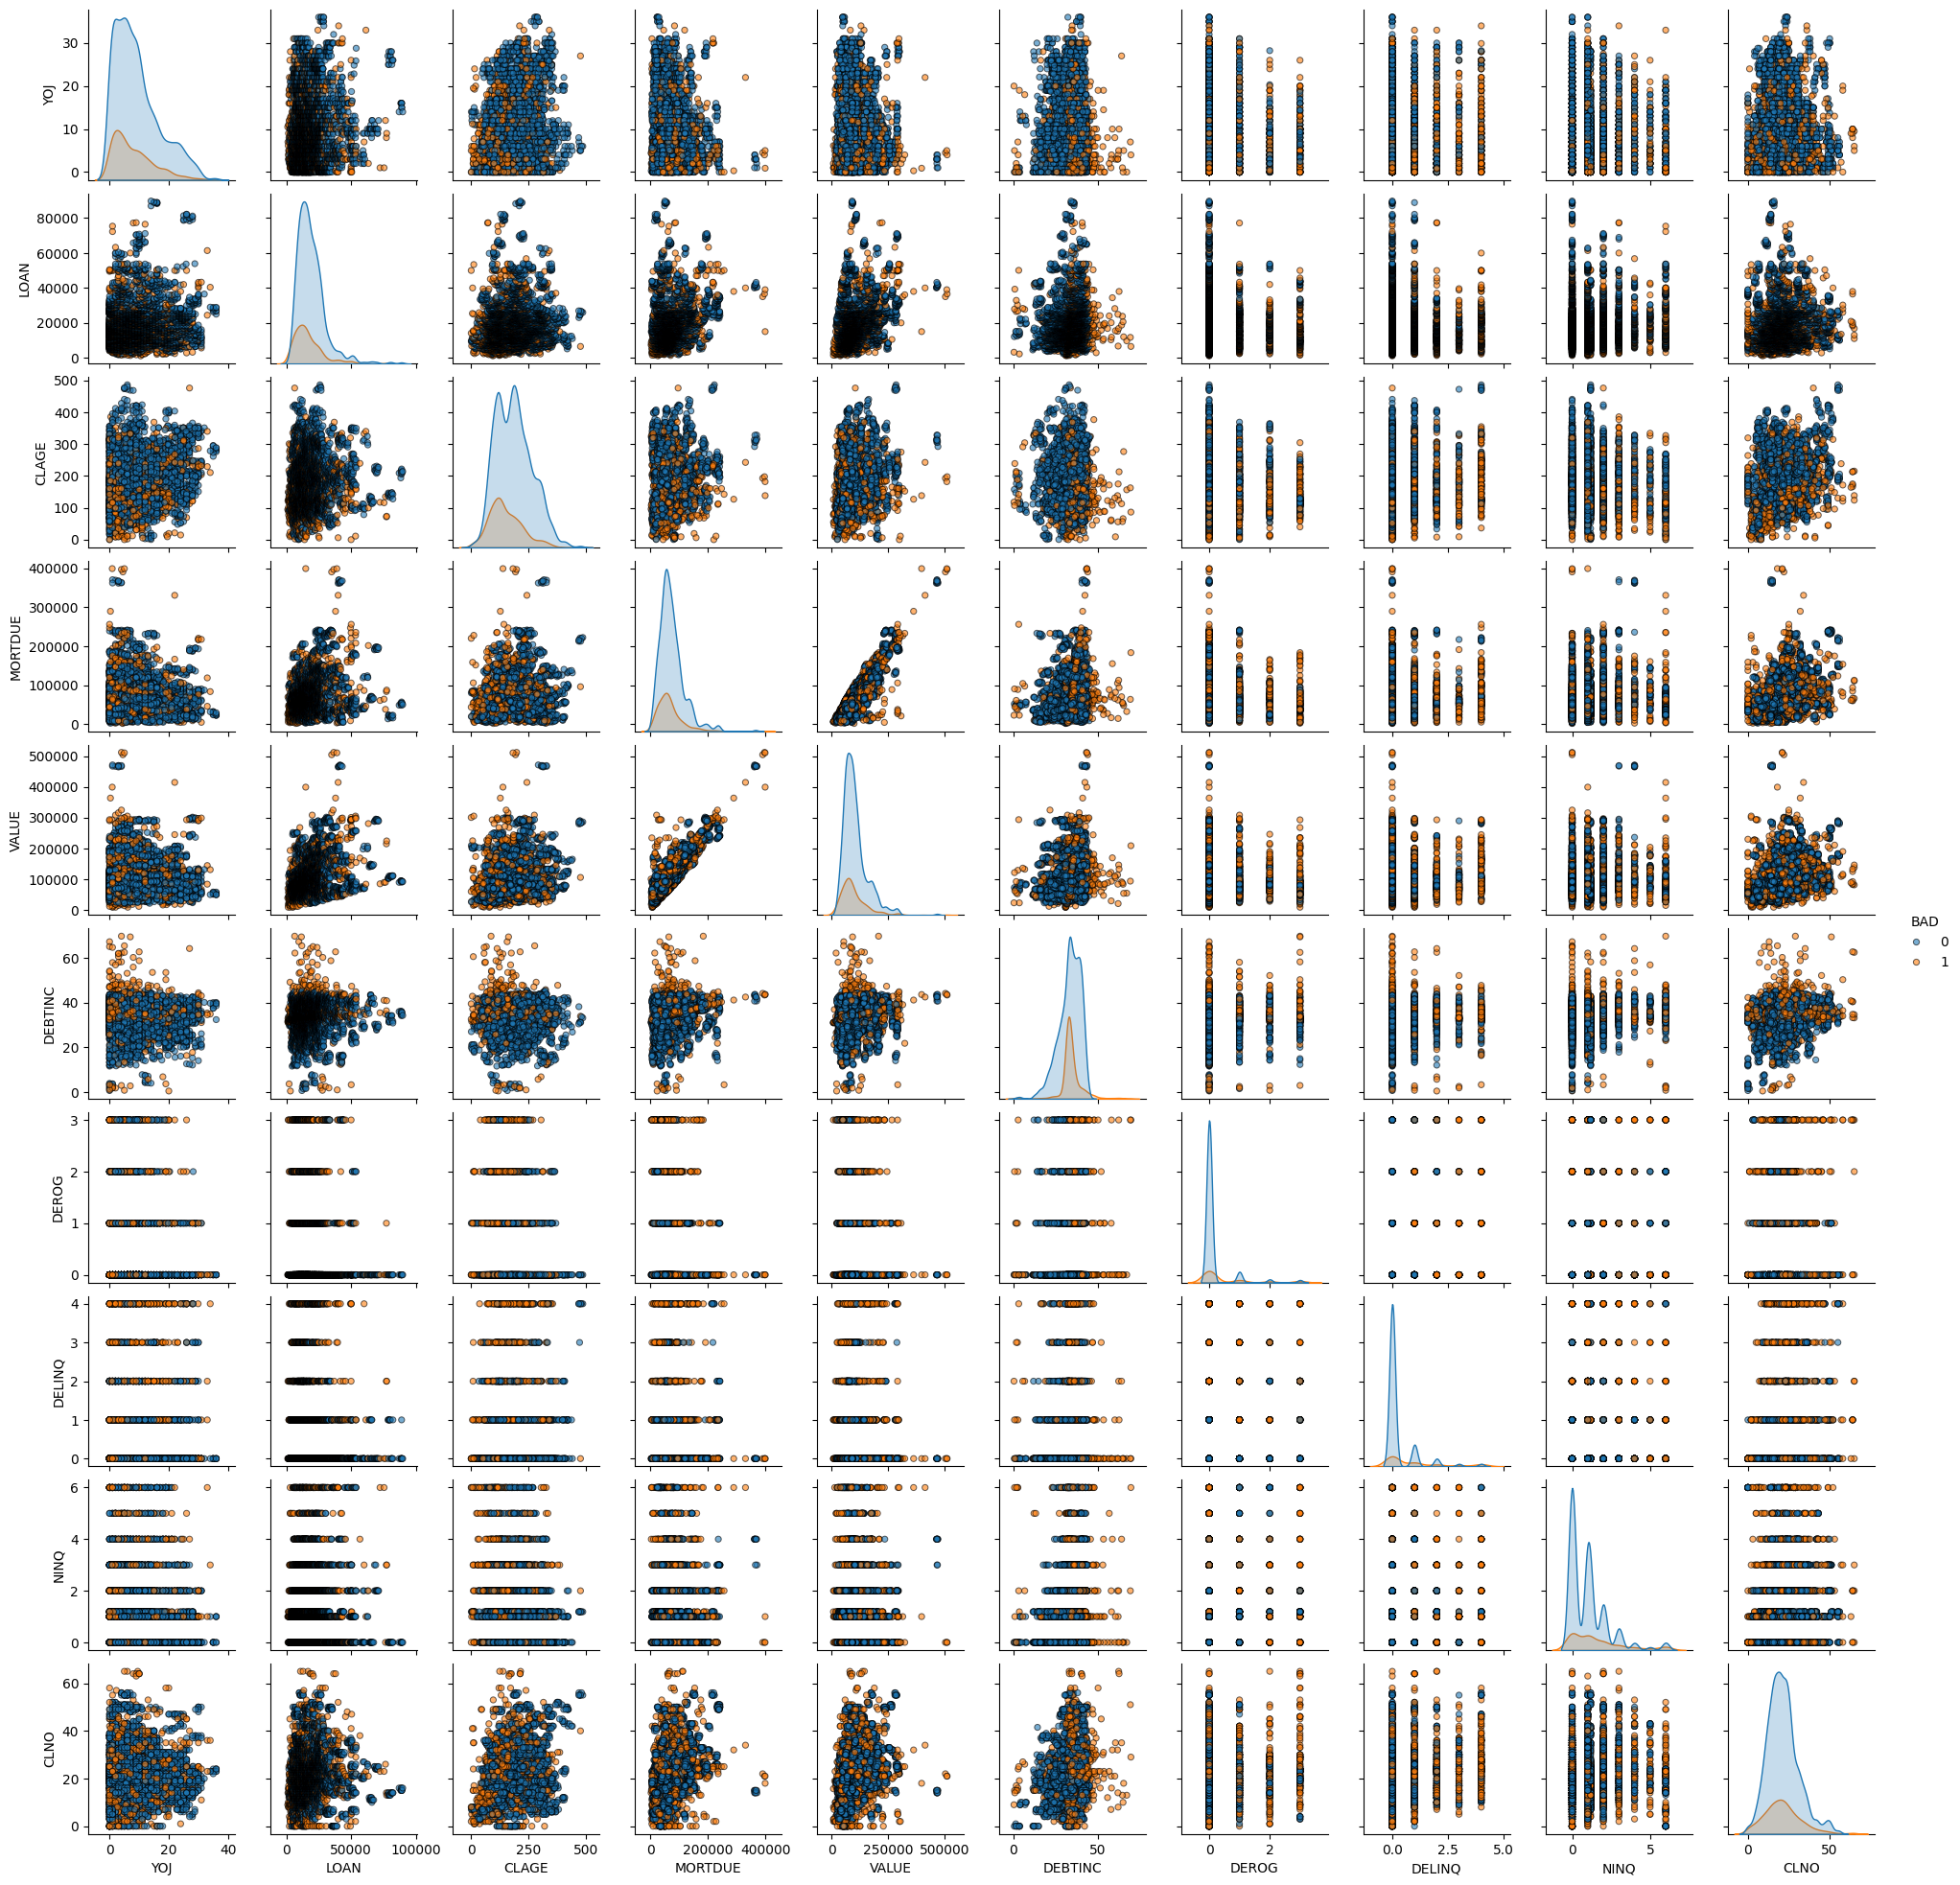

In [13]:
sns.pairplot(data=df, vars=num_features+ordinal_features, hue=target_feature, diag_kind='kde', dropna=True, markers = '.',
             plot_kws={'alpha':0.6, 's':80, 'edgecolor':'k'}, height=2);

### **Analyse Multivariée**

In [14]:
# Fonction utilitaire pour l'encodage du jeu de données
def encode_data(df: pd.DataFrame, nominal_features: List[str], ordinal_features: List[str], num_features: List[str], 
                drop_first: bool = True, encode_boolean: bool = True, encoders: Optional[dict] = None) -> pd.DataFrame:
    """Encode les données du DataFrame.

    Args:
        df (pd.DataFrame): DataFrame contenant les données.
        nominal_features (List[str]): Liste des variables nominales.
        drop_first (bool, optional): Supprimer la première colonne du one-hot encoding. Par défaut à True.
        ordinal_features (List[str]): Liste des variables ordinales.
        num_features (List[str]): Liste des variables numériques.
        encoders (Optional[dict], optional): Dictionnaire contenant les encodeurs. Par défaut à None.

    Returns:
        pd.DataFrame: DataFrame avec les données encodées.
    """
    if not encoders:
        encoders = {}

    # Encodage des variables nominales avec OneHotEncoder
    if nominal_features:
        for col in nominal_features:
            if encoders.get(col):  # Vérifier si la colonne a déjà été encodée
                continue
            enc = OneHotEncoder(drop=None)
            enc_cols = enc.fit_transform(df[col].values.reshape(-1, 1)).toarray()
            df[enc.categories_[0][0:]] = enc_cols
            df.drop(columns=[col], inplace=True)

            # Supprimer la colonne "nan" si elle est créée à cause des valeurs manquantes
            if any([np.isnan(item) for item in enc.categories_[0] if not isinstance(item, str)]):
                df.drop(columns=[np.nan], inplace=True)

            # Filtrer les catégories réelles (exclure les NaN)
            real_cats = [item for item in enc.categories_[0] if isinstance(item, str)]

            # Supprimer la première catégorie (si drop_first est activé)
            if drop_first:
                df.drop(columns=real_cats[0], inplace=True)

            encoders[col] = enc

    # Encodage des variables ordinales avec OrdinalEncoder
    if ordinal_features:
        for col in ordinal_features:
            if encoders.get(col):  # Vérifier si la colonne a déjà été encodée
                continue
            enc = OrdinalEncoder()
            df[col] = enc.fit_transform(df[col].values.reshape(-1, 1))
            encoders[col] = enc

    # Mise à l'échelle des variables numériques avec MinMaxScaler
    if num_features:
        for col in num_features:
            if encoders.get(col):  # Vérifier si la colonne a déjà été encodée
                continue
            enc = MinMaxScaler()
            df[col] = enc.fit_transform(df[col].values.reshape(-1, 1))

    # Encodage des variables booléennes avec LabelEncoder
    if encode_boolean:
        for col in df.select_dtypes(include=['bool']).columns:
            if encoders.get(col):  # Vérifier si la colonne a déjà été encodée
                continue
            enc = LabelEncoder()
            df[col] = enc.fit_transform(df[col].values.reshape(-1, 1))
            encoders[col] = enc

    return df, encoders


#### Première caractérisation des prêts en défaut à l'aide de l'ACP (PCA)

Nous allons essayer d'identifier certaines caractéristiques de la classe des prêts en défaut.

*REMARQUE* : L'ACP (PCA) nécessite que les caractéristiques soient encodées et mises à l'échelle. 
Ici, un StandardScaler est utilisé.


In [15]:
# Créer un jeu de données propre en supprimant les valeurs manquantes ; nous l'utiliserons uniquement pour l'exploration initiale
df_clean = df.dropna()

# Encoder les données pour l'ACP (PCA)
df_clean, encoders = encode_data(df_clean, nominal_features=nominal_features, ordinal_features=ordinal_features, num_features=None, 
                                 drop_first=False, encode_boolean=False, encoders=None)

# Séparer les caractéristiques de la cible
X = df_clean.drop(columns=[target_feature])
y = df_clean[target_feature]

# Utiliser le StandardScaler pour mettre à l'échelle toutes les caractéristiques
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X), columns=X.columns)

# Vérifier le résultat final
X.sample(10)


,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
3421,-0.038954,-1.117292,0.653999,-0.128618,-0.350376,-0.457059,2.278955,-0.261907,-1.233290,1.099737,0.668866,-0.668866,-0.388051,-0.43966,1.147780,-0.538385,-0.136387,-0.183672
3216,-0.120081,-0.189364,-0.169734,-0.533865,-0.350376,-0.457059,-0.570630,-0.819272,-1.210119,-0.914640,-1.495068,1.495068,-0.388051,-0.43966,-0.871247,1.857407,-0.136387,-0.183672
3242,-0.102053,0.141965,-0.017718,-1.209276,-0.350376,-0.457059,-0.369958,-0.261907,-0.572896,0.122388,0.668866,-0.668866,-0.388051,-0.43966,1.147780,-0.538385,-0.136387,-0.183672
4089,0.267526,0.837254,1.064286,0.952039,-0.350376,-0.457059,0.223131,-0.819272,0.840581,-0.180166,0.668866,-0.668866,2.576980,-0.43966,-0.871247,-0.538385,-0.136387,-0.183672
5837,3.170072,-1.034859,-0.425212,-0.804030,2.777358,-0.457059,0.834812,3.082284,-1.013159,1.419738,-1.495068,1.495068,-0.388051,-0.43966,1.147780,-0.538385,-0.136387,-0.183672
5407,1.241051,3.749663,2.430455,-0.804030,-0.350376,0.616005,0.419727,1.410188,1.570492,1.158556,0.668866,-0.668866,2.576980,-0.43966,-0.871247,-0.538385,-0.136387,-0.183672
2790,-0.255293,0.547918,0.365325,0.141546,-0.350376,-0.457059,-0.088431,-0.819272,1.083885,0.415497,0.668866,-0.668866,-0.388051,-0.43966,1.147780,-0.538385,-0.136387,-0.183672
1984,-0.507688,-0.724583,-0.885312,1.762533,-0.350376,-0.457059,-0.755463,-0.819272,0.504591,0.770566,-1.495068,1.495068,-0.388051,-0.43966,1.147780,-0.538385,-0.136387,-0.183672
4822,0.628091,0.195375,0.280032,0.006464,-0.350376,-0.457059,-0.802303,-0.819272,-0.422279,-1.068105,0.668866,-0.668866,-0.388051,-0.43966,-0.871247,1.857407,-0.136387,-0.183672
1687,-0.597829,0.291006,1.948041,0.816957,-0.350376,-0.457059,-2.104091,0.295458,-1.291220,-2.308770,-1.495068,1.495068,-0.388051,-0.43966,-0.871247,-0.538385,-0.136387,5.444491


In [16]:
def color_high(val):
    """Fonction d'aide pour colorier les valeurs dans un dataframe

    Args:
        val : Valeur de la cellule

    Returns:
        Une couleur
    """
    if val < -0.25:  # Vous pouvez choisir n'importe quelle valeur selon votre compréhension
        return 'background: pink'
    elif val > 0.25:
        return 'background: skyblue'

def execute_PCA(data: pd.DataFrame, explain_limit: float = 0.7, max_components: int = -1, random_state: int = 42):
    """Effectue une analyse en composantes principales (PCA) et renvoie le dataframe des résultats de la PCA et celui des composants

    Args:
        data (pd.DataFrame): DataFrame des caractéristiques
        explain_limit (float, optional): Limite minimale pour expliquer la variance; permet de déterminer combien de composants inclure dans le résultat. Par défaut, 0.7.
        max_components (int, optional): Limite les composants retournés. Par défaut, -1 (aucune limite).
        random_state (int, optional): L'état aléatoire. Par défaut, 42.

    Returns:
        tuple de dataframes avec les résultats de la PCA et les composants
    """
    n = data.shape[1]
    pca = PCA(n_components=n, random_state=random_state)
    data_pca = pd.DataFrame(pca.fit_transform(data))

    # Le pourcentage de variance expliqué par chaque composant principal
    exp_var = pca.explained_variance_ratio_
    # Trouver le nombre minimal de composants pouvant expliquer plus de 70% de la variance
    sum = 0
    for ix, i in enumerate(exp_var):
        sum = sum + i
        if sum > explain_limit:
            break

    components = ix + 1
    if max_components > 0 and components > max_components:
        components = min(components, max_components)

    pc_comps = [f'PC{i}' for i in range(1, components + 1)]

    components_pca = pd.DataFrame(np.round(pca.components_[:components, :], 2), index=pc_comps, columns=data.columns)
    return data_pca, components_pca


In [17]:
# Effectuer la PCA sur les prêts en défaut
bad_loans = X.copy()
bad_loans[target_feature] = y
bad_loans.dropna(inplace=True)
bad_loans = bad_loans[bad_loans[target_feature]==1]
bad_loans.drop(columns=[target_feature], inplace=True)
data_pca, components_pca = execute_PCA(bad_loans, explain_limit=0.7)
if float(pd.__version__.split('.')[0]) < 2:
  result = components_pca.T.style.applymap(color_high)
else:
  result = components_pca.T.style.map(color_high)
result

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
LOAN,0.330000,-0.130000,-0.050000,-0.000000,-0.130000,0.090000,-0.100000,-0.110000
MORTDUE,0.400000,-0.210000,-0.140000,-0.260000,-0.040000,-0.050000,0.000000,-0.170000
VALUE,0.450000,-0.180000,-0.170000,-0.260000,-0.080000,-0.040000,-0.060000,-0.160000
YOJ,0.040000,0.030000,-0.100000,0.100000,0.090000,-0.130000,-0.030000,-0.060000
DEROG,0.170000,0.690000,0.470000,-0.390000,-0.170000,-0.080000,-0.280000,-0.020000
DELINQ,0.260000,0.590000,-0.440000,0.430000,0.230000,0.040000,0.040000,-0.070000
CLAGE,0.120000,0.040000,-0.160000,0.080000,0.150000,-0.060000,-0.030000,-0.160000
NINQ,0.150000,0.110000,0.240000,0.040000,-0.270000,0.310000,0.810000,-0.120000
CLNO,0.320000,0.080000,0.040000,0.080000,0.110000,-0.030000,0.180000,-0.090000
DEBTINC,0.150000,-0.140000,0.080000,-0.100000,-0.060000,-0.010000,-0.050000,0.050000


**PC1 (Composante Principale 1) :**
- **Variables les plus influentes** : MORTDUE, VALUE, LOAN.  
Cette composante principale semble capturer une tendance générale liée aux variables financières importantes, telles que le montant du prêt (LOAN), la valeur de la maison (VALUE), et le montant dû (MORTDUE). Les coefficients positifs de ces variables suggèrent qu'une augmentation de ces valeurs pourrait être associée à un changement dans cette première composante.

**PC2 (Composante Principale 2) :**
- **Variables les plus influentes** : DEROG, DELINQ.  
La deuxième composante est fortement influencée par les antécédents de crédit et le nombre de défauts de paiement (DEROG et DELINQ), indiquant qu'elle reflète probablement la sévérité des problèmes financiers ou des retards de paiement.

**PC3 (Composante Principale 3) :**
- **Variables les plus influentes** : Sales, DebtCon, DELINQ.  
Cette composante semble capturer une tendance liée à la vente (Sales), à la consolidation de dettes (DebtCon), et à la situation des paiements en retard (DELINQ), mettant en lumière une relation avec les aspects commerciaux et les dettes consolidées.

**PC4 (Composante Principale 4) :**
- **Variables les plus influentes** : DebtCon, HomeImp.  
La quatrième composante est principalement influencée par les variables liées à la consolidation de dettes (DebtCon) et à l'amélioration de l'habitat (HomeImp). Cela pourrait indiquer une corrélation entre les prêts pour améliorer la maison et les processus de consolidation des dettes.

**PC5 (Composante Principale 5) :**
- **Variables les plus influentes** : Sales, HomeImp.  
La cinquième composante semble liée à des variables qui affectent le secteur des ventes (Sales) et les prêts pour améliorer la maison (HomeImp), suggérant une corrélation avec les prêts à des fins spécifiques.

**PC6 (Composante Principale 6) :**
- **Variables les plus influentes** : Self, NINQ, Mgr.  
Cette composante est influencée par des variables liées à l'auto-emploi (Self), au nombre de demandes de crédit (NINQ), et à la gestion (Mgr), ce qui pourrait indiquer une relation avec les caractéristiques personnelles ou professionnelles de l'individu.

**PC7 (Composante Principale 7) :**
- **Variables les plus influentes** : NINQ, Mgr, DebtCon.  
La septième composante est influencée par le nombre d'enquêtes de crédit (NINQ), la gestion (Mgr) et la consolidation des dettes (DebtCon), ce qui pourrait indiquer une corrélation avec les aspects financiers et la gestion de dettes dans la vie personnelle.

**PC8 (Composante Principale 8) :**
- **Variables les plus influentes** : Other, Self.  
La dernière composante semble refléter des facteurs moins directement liés aux aspects financiers traditionnels, mais plutôt à des variables moins conventionnelles comme "Other" (autres) et "Self" (auto-emploi).

---

**Résumé :**
- **PC1** reflète principalement la situation financière générale (prêts, valeur des biens, montants dus).
- **PC2** et **PC3** sont davantage liées aux antécédents de crédit et aux problèmes de paiement.
- **PC4** et **PC5** montrent des liens avec la consolidation des dettes et l'amélioration de l'habitat.
- **PC6**, **PC7**, et **PC8** révèlent des informations sur les profils personnels, le nombre d'enquêtes de crédit, ainsi que les types de prêts ou d'emplois spécifiques.


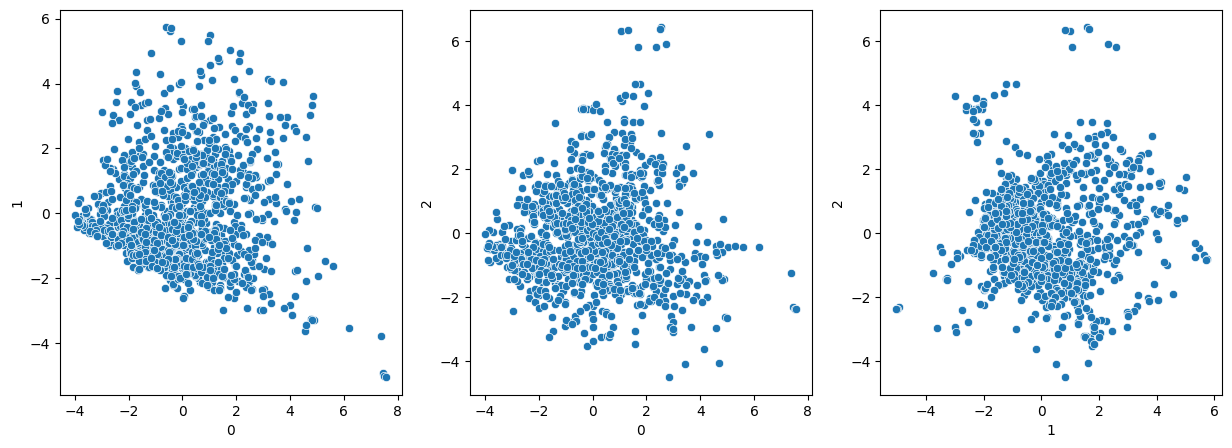

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
sns.scatterplot(x = data_pca[0], y = data_pca[1], ax=axs[0])
sns.scatterplot(x = data_pca[0], y = data_pca[2], ax=axs[1])
sns.scatterplot(x = data_pca[1], y = data_pca[2], ax=axs[2])
plt.show();

# **Construction du modèle**

Tâches à accomplir :
- Préparation des données
- Partitionner les données en ensemble d'entraînement et ensemble de test
- Construire les modèles
- Entraîner sur les données d'entraînement
- Ajuster le modèle
- Tester le modèle sur l'ensemble de tes

In [19]:
# Fixer l'état aléatoire
random_state = 42
# Nous utiliserons 20% des données pour les tests
test_size = 0.2

def init_random_state(random_state:int=42):
    """Méthode simple pour définir l'état aléatoire afin d'assurer la reproductibilité

    Args:
        random_state (int, optional): Une graine entière. Par défaut 42.
    """
    random.seed(1)
    np.random.seed(1)
    try:
        # Si tensorflow est importé (en tant que tf), définir également la graine aléatoire de tensorflow
        tf.random.set_seed(1)
    except:
        pass

### Encodage

In [20]:
# Étape 2 : Encodage des variables catégoriques

# Encodage des variables catégoriques avec One-Hot Encoding
df = pd.get_dummies(df, columns=["REASON", "JOB"])

# Vérifier la structure des données après encodage
df.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1100.0,25860.0,39025.0,10.50,0.0,0.0,94.366667,1.000000,9.00,31.603711,False,True,False,False,True,False,False,False
1,1,1300.0,70053.0,70053.0,7.00,0.0,2.0,121.833333,0.000000,14.00,32.975041,False,True,False,False,True,False,False,False
2,1,1500.0,13500.0,16700.0,4.00,0.0,0.0,149.466667,1.000000,10.00,31.238346,False,True,False,False,True,False,False,False
3,1,1500.0,6318.0,8796.0,6.15,3.0,0.0,125.715233,1.186743,15.71,31.016780,False,True,False,False,True,False,False,False
4,0,1700.0,97800.0,112000.0,3.00,0.0,0.0,93.333333,0.000000,14.00,33.846982,False,True,False,True,False,False,False,False


In [21]:
# Bien que pour les modèles basés sur les arbres, nous n'ayons pas besoin de mettre à l'échelle les données,
# nous le ferons pour assurer la cohérence avec les autres modèles (Régression Logistique, etc.).
df, encoders = encode_data(df, nominal_features=nominal_features, drop_first=False, 
                           ordinal_features=ordinal_features, num_features=num_features,
                           encode_boolean=True, encoders=encoders)

# Vérifier un échantillon du dataframe
df.sample(10)

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
5161,0,0.303269,0.236365,0.235693,0.000000,1.0,0.0,0.404415,3.000000,37.00,0.495801,1,0,0,0,0,1,0,0
4611,0,0.262683,0.215793,0.189880,0.166667,3.0,0.0,0.262599,1.186743,18.78,0.429526,0,1,1,0,0,0,0,0
552,0,0.071026,0.125566,0.100281,0.111111,0.0,0.0,0.171515,0.000000,18.00,0.330174,0,1,0,0,1,0,0,0
3345,0,0.188275,0.029626,0.322677,0.638889,0.0,0.0,0.178421,2.000000,21.00,0.445105,0,1,1,0,0,0,0,0
4827,0,0.275085,0.279609,0.348841,0.472222,1.0,0.0,0.635788,1.000000,31.00,0.488385,1,0,0,0,0,0,1,0
5348,1,0.337091,0.165366,0.188029,0.194444,0.0,1.0,0.240560,1.000000,31.00,0.628514,1,0,1,0,0,0,0,0
3936,0,0.220970,0.097958,0.111548,0.722222,0.0,0.0,0.628191,3.000000,32.00,0.466647,1,0,0,0,1,0,0,0
3798,1,0.213078,0.030939,0.081778,0.444722,0.0,1.0,0.444632,1.000000,10.00,0.454381,1,0,0,0,1,0,0,0
1030,0,0.094701,0.141192,0.110707,0.166667,0.0,4.0,0.263106,1.000000,11.00,0.545265,1,0,1,0,0,0,0,0
1470,0,0.111612,0.287552,0.266986,0.416667,0.0,1.0,0.372616,1.000000,32.00,0.425953,1,0,0,0,0,1,0,0


Division en ensembles d'entraînement et de test


In [22]:
# Création des variables de caractéristiques et du vecteur cible
X = df.drop(columns=[target_feature])
y = df[target_feature]

In [23]:
# Création des ensembles de données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [24]:
# Calculer les occurrences de chaque classe dans l'ensemble d'entraînement
weights = y_train.value_counts(normalize=True)
# Déterminer les poids des classes - ceci est un hyperparamètre
class_weight = {0: weights[1], 1: weights[0]} 

In [25]:
# Créer une colonne 'missing_values' dans X_train qui compte les valeurs manquantes pour chaque ligne
X_train['missing_values'] = X_train.isna().sum(axis=1)
X_test['missing_values'] = X_test.isna().sum(axis=1)
X['missing_values'] = X.isna().sum(axis=1)



In [26]:
sample_weight = len(cat_features + num_features) - X_train['missing_values']
sample_weight.value_counts()

# Nous aurons besoin d'une copie pour la sous-échantillonnage et la sur-échantillonnage
missing_values = X_train['missing_values'].copy()

# Maintenant, supprimer la caractéristique de l'ensemble d'entraînement, de test et du jeu de caractéristiques
# (que nous utiliserons plus tard pour le sous-échantillonnage et le sur-échantillonnage)
X_train.drop(columns=['missing_values'], inplace=True)
X_test.drop(columns=['missing_values'], inplace=True)
X.drop(columns=['missing_values'], inplace=True)

**REMARQUE**  
L'entraînement du modèle, son optimisation, son évaluation et la sélection du seuil optimal sont tous contenus dans les fonctions suivantes.

In [27]:
# **Fonctions utilitaires pour l'exécution et l'évaluation des modèles**

def plot_confusion_matrix(ax, cm, labels:list=None, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    Cette fonction affiche et trace la matrice de confusion.
    La normalisation peut être appliquée en définissant `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Matrice de confusion normalisée'
        else:
            title = 'Matrice de confusion sans normalisation'

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)

    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, ax=ax, cmap=cmap, cbar=False)
    ax.set_ylabel('Réel')
    ax.set_xlabel('Prédit')
    ax.set_title(title)

def plot_classification_report(ax:plt.Axes, cr:dict, labels:list=None, title:str=None, cmap:plt.cm=plt.cm.Blues, rounding:int=4):
    """Affiche le rapport de classification sous forme de tableau

    Args:
        ax (plt.Axes): L'objet axes pour afficher le graphique
        cr (dict): Résultat de l'appel à sklearn.metrics.classification_report avec output_dict=True
        labels (list, optional): Étiquettes des classes. Par défaut, None.
        title (str, optional): Titre du rapport. Par défaut, None.
        cmap (plt.cm, optional): Colormap à utiliser. Par défaut, plt.cm.Blues.
        rounding (int, optional): Nombre de décimales à arrondir. Par défaut, 4.
    """
    if not title:
        title = 'Rapport de classification'

    # Conversion du dictionnaire en DataFrame pour une manipulation plus facile
    df = pd.DataFrame(cr)
    # Extraction de la précision globale qui n'est pas définie par classe
    accuracy = df['accuracy'].iloc[0]
    # Suppression de la colonne "accuracy" pour rendre le DataFrame plus lisible
    df.drop(columns=['accuracy'], inplace=True)
    # Renommage des colonnes avec les étiquettes des classes
    df.rename(columns={'0': labels[0], '1': labels[1]}, inplace=True)
    # Arrondi des valeurs selon le paramètre `rounding`
    df = df.round(rounding)
    # Configuration du tableau
    ax.axis('off')
    ax.set_title(title)
    table = ax.table(cellText=np.vstack([df.values, [f'{accuracy:.4f}', '', '', '']]),
                      colLabels=df.columns,
                      rowLabels=df.index.to_list() + ['Précision'],
                      rowColours=['lightgrey'] * df.shape[0] + ['lightgrey'],
                      colColours=['lightgrey'] * df.shape[1],
                      bbox=[0.06, 0.3, 0.95, 0.7])
    table.auto_set_font_size(False)
    table.set_fontsize(9)


def combined_metrics_score(y_train:pd.Series, y_train_pred:pd.Series, y_test:pd.Series=None, y_test_pred:pd.Series=None, 
                           labels: list = None, normalize: bool = False, title: str = None):
    """Affiche une matrice de confusion et un rapport de classification pour les ensembles d'entraînement et de test.

    Args:
        y_train (pd.Series): Ensemble d'entraînement des classes réelles.
        y_train_pred (pd.Series): Classes prédites pour l'ensemble d'entraînement.
        y_test (pd.Series, optional): Ensemble de test des classes réelles. Par défaut, None.
        y_test_pred (pd.Series, optional): Classes prédites pour l'ensemble de test. Par défaut, None.
        labels (list, optional): Étiquettes des classes. Par défaut, None.
        normalize (bool, optional): Si vrai, la matrice de confusion sera normalisée. Par défaut, False.
        title (str, optional): Titre du graphique. Par défaut, None.

    Raises:
        ValueError: Si l'ensemble d'entraînement ou les prédictions associées sont None.

    Returns:
        tuple: Les rapports de classification pour les ensembles d'entraînement et de test.
    """
    if y_train is None or y_train_pred is None:
        raise ValueError('y_train et y_train_pred ne peuvent pas être None')
    if y_test is None or y_test_pred is None:
        test_output = False
    else:
        test_output = True
    
    cols = 1
    cr_test = None
    # Calcul du rapport de classification
    cr_train = classification_report(y_train, y_train_pred, output_dict=True)
    if test_output:
        cols = 2
        cr_test  = classification_report(y_test, y_test_pred, output_dict=True)
    
    # Calcul de la matrice de confusion
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = None
    if test_output:
        cm_test = confusion_matrix(y_test, y_test_pred)

    # Affichage des résultats
    fig, axes = plt.subplots(cols, 2, figsize=(10, 7))
    plot_classification_report(axes[0][0], cr_train, labels=labels, title="Classification entraînement")
    plot_confusion_matrix(axes[1][0], cm_train, labels=labels, normalize=normalize, title="Matrice de confusion entraînement", cmap=plt.cm.Blues)
    if test_output:
        plot_classification_report(axes[0][1], cr_test, labels=labels, title="Classification test")
        plot_confusion_matrix(axes[1][1], cm_test, labels=labels, normalize=normalize, title="Matrice de confusion test", cmap=plt.cm.Reds)

    fig.tight_layout()
    plt.show()
    # Retourne les rapports de classification
    return cr_train, cr_test

def plot_tree(estimator, feature_names):
    """Affiche un arbre de décision.

    Args:
        estimator (DecisionTreeClassifier): L'estimateur DecisionTreeClassifier.
        feature_names (Iterable): Noms des caractéristiques utilisées dans l'arbre.
    """

    plt.figure(figsize=(36, 36))

    out = tree.plot_tree(estimator, fontsize=10, max_depth=5, impurity=False, filled=True, 
                         feature_names=feature_names, class_names=True)
    # Colorer les flèches en rouge et augmenter l'épaisseur des lignes
    for o in out:      
        arrow = o.arrow_patch
        if arrow is not None:
            arrow.set_edgecolor('red')
            arrow.set_linewidth(3)

    # Affichage du graphique       
    plt.show()


def fit_model(classifier: Callable, X_train: pd.DataFrame, y_train: pd.Series, class_weight: [dict,str]=None, 
              sample_weight: pd.Series=None, optimisation_params: dict=None, model_params: dict=None, 
              n_jobs:[int,None]=None, random_state:int=-1, verbose:int=0, plot:bool=False):
    """
    Entraîne un classificateur et retourne le modèle ainsi que les prédictions sur l’ensemble de test.

    Args:
        classifier (Callable): Fonction du classificateur.
        X_train (pd.DataFrame): Ensemble d'entraînement.
        y_train (pd.Series): Étiquettes de l’ensemble d'entraînement.
        class_weight ([dict, str], optional): Pondération des classes pour le classificateur. Defaults à None.
        sample_weight (pd.Series, optional): Poids des échantillons. Defaults à None.
        optimisation_params (dict, optional): Paramètres d’optimisation pour GridSearchCV. Defaults à None.
        model_params (dict, optional): Hyperparamètres du classificateur. Defaults à None.
        n_jobs ([int, None], optional): Nombre de threads pour l’optimisation. Defaults à None.
        random_state (int, optional): Graine aléatoire pour la reproductibilité. Defaults à -1.
        verbose (int, optional): Niveau de verbosité. Defaults à 0.
        plot (bool, optional): Si True, affiche l’arbre de décision. Defaults à False.

    Returns:
        estimator: Modèle entraîné.
    """
    init_random_state(random_state)  # Initialise la graine aléatoire

    if not model_params:
        model_params = {}

    # Ajoute la pondération des classes si spécifiée
    if class_weight:
        model_params['class_weight'] = class_weight
    if random_state != -1:
        model_params['random_state'] = random_state

    # Création du classificateur avec les paramètres fournis
    clf = classifier(**model_params)

    if optimisation_params:
        # Si les classes sont déséquilibrées, utilise la validation croisée stratifiée
        if class_weight:
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state)
        else:
            cv = 5

        # Recherche des meilleurs hyperparamètres via GridSearchCV
        model = GridSearchCV(clf, cv=cv, param_grid=optimisation_params, n_jobs=n_jobs)
        result = model.fit(X_train, y_train, sample_weight=sample_weight)
        estimator = result.best_estimator_
    else:
        result = clf.fit(X_train, y_train)
        estimator = result

    # Si demandé, affiche l’arbre de décision
    if plot:
        plot_tree(estimator, X_train.columns)
    
    return estimator


def get_best_prediction(model, X_train: pd.DataFrame, y_train:pd.Series, X_test:pd.DataFrame, y_test:pd.Series, plot=False):
    """
    Détermine le seuil optimal pour un modèle donné en utilisant la courbe ROC. Affiche les résultats si demandé.

    Args:
        model (_type_): Modèle entraîné.
        X_train (pd.DataFrame): Ensemble d'entraînement.
        y_train (pd.Series): Étiquettes de l’ensemble d'entraînement.
        X_test (pd.DataFrame): Ensemble de test.
        y_test (pd.Series): Étiquettes de l’ensemble de test.
        plot (bool, optional): Si True, affiche la courbe ROC et le seuil optimal. Defaults à False.

    Returns:
        tuple: (Prédictions optimales sur l’ensemble d'entraînement, prédictions optimales sur l’ensemble de test, score ROC AUC).
    """
    # Prédit les probabilités des classes
    yhat = model.predict_proba(X_test)
    probabilities = yhat[:, 1]  # Récupère les probabilités de la classe positive

    # Calcule les courbes ROC
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)

    # Calcule le g-mean pour chaque seuil
    gmeans = np.sqrt(tpr * (1-fpr))
    
    # Détermine l'indice du seuil optimal
    ix = np.argmax(gmeans)
    threshold = thresholds[ix]

    # Calcule le score ROC AUC
    roc_auc = roc_auc_score(y_test, yhat[:, 1])

    print(f'Seuil optimal={threshold:.2f} G-Mean={gmeans[ix]:.2f} ROC AUC={roc_auc:.2f}')

    # Affiche la courbe ROC si demandé
    if plot:
        plt.plot([0,1], [0,1], linestyle='--', label='Sans compétence')
        plt.plot(fpr, tpr, marker='.', markersize=1)
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Meilleur seuil')
        plt.xlabel('Taux de faux positifs')
        plt.ylabel('Taux de vrais positifs')
        plt.legend()
        plt.show()

    # Applique le seuil optimal aux prédictions
    y_train_pred = model.predict(X_train) > threshold
    y_test_pred = model.predict(X_test) > threshold

    return y_train_pred, y_test_pred, roc_auc


In [28]:
# Nous allons stocker les métriques de performance de tous les modèles dans un dictionnaire
models = {}

# Nommer les classes
labels=['Repaid', 'Defaulted']

### Régression Logistique

In [29]:
# Définir les paramètres à optimiser pour GridSearchCV
optimisation_params = None  # Aucune optimisation par recherche de grille
model_params = {'penalty': 'l2', 'n_jobs': n_jobs}  # Régularisation L2 et parallélisation

# Maintenant, ajuster le modèle optimal et ne pas tracer l'arbre de décision
lg_model_simple = fit_model(
    linear_model.LogisticRegression,  # Modèle de régression logistique
    X_train, y_train,  
    optimisation_params=optimisation_params, 
    model_params=model_params,
    sample_weight=sample_weight, 
    random_state=random_state, 
    plot=False
)

Seuil optimal=0.19 G-Mean=0.71 ROC AUC=0.78


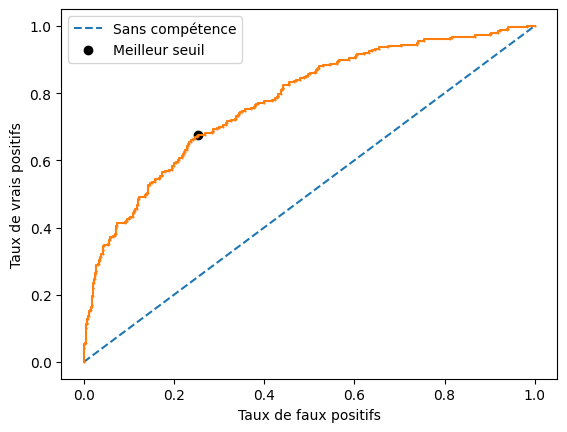

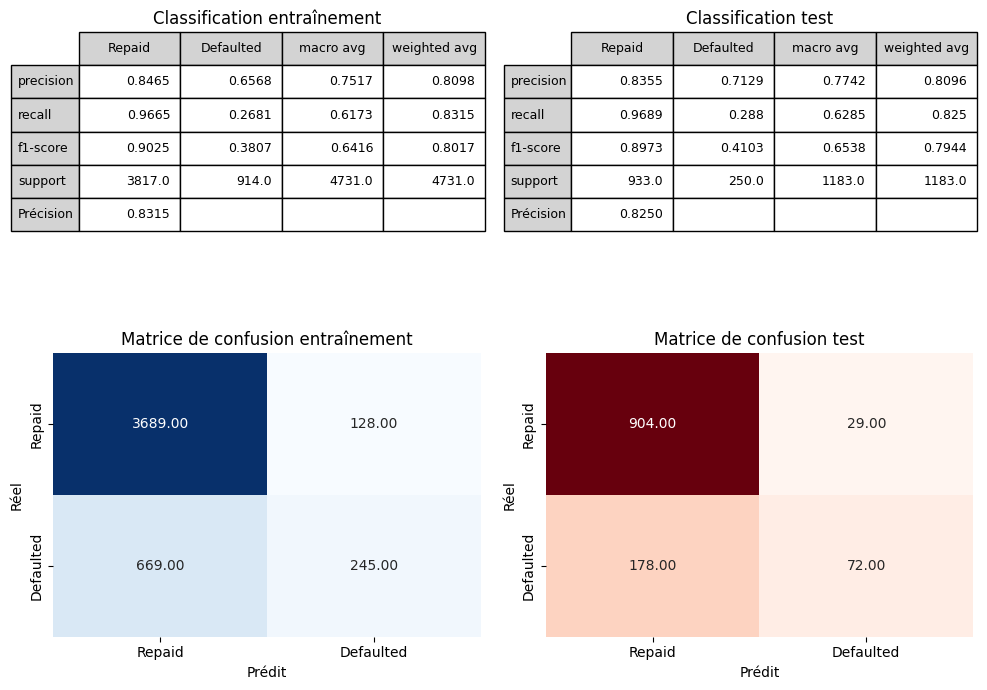

In [30]:
# Obtenir les prédictions sur les ensembles d'entraînement et de test
# et déterminer la meilleure prédiction à partir du seuil optimal
y_train_pred, y_test_pred, roc_auc = get_best_prediction(
    lg_model_simple, X_train, y_train, X_test, y_test, plot=True
)

# Calculer et afficher les résultats des métriques pour les ensembles d'entraînement et de test
dt_simple_cr_train, dt_simple_cr_test = combined_metrics_score(
    y_train, y_train_pred, y_test, y_test_pred, labels=labels, normalize=False
)

# Ajouter les résultats du modèle dans le dictionnaire des modèles avec la métrique ROC AUC
models['Logistic Regression'] = [dt_simple_cr_train, dt_simple_cr_test, {'roc_auc': roc_auc}]

### **Arbre de Décision - Optimisation des Hyperparamètres**

Nous avons décidé d'utiliser les hyperparamètres suivants :
- criterion
- max_depth
- min_samples_leaf
- class_weight (pour gérer le déséquilibre des classes)
- ccp_alpha pour l'élagage

De nombreuses combinaisons ont été testées, et seul le résultat est affiché. En général, nous avons ajusté les valeurs en fonction des paramètres optimaux trouvés par recherche de grille.

In [31]:
# Définir les paramètres à optimiser pour GridSearchCV
optimisation_params = {
    'criterion': ['gini', 'entropy'],  # Critères de division (gini ou entropie)
    'max_depth': [4, 5, 6, 7],  # Profondeur maximale de l'arbre
    'min_samples_leaf': [1, 5, 10],  # Nombre minimum d'échantillons par feuille
    'class_weight': [None, 'balanced', class_weight, {0: 0.1, 1: 0.9}],  # Pondération des classes pour gérer le déséquilibre
    'ccp_alpha': [0.0, 0.001, 0.01]  # Paramètre d'élagage (pruning)
}

# Maintenant, ajuster le modèle optimal et ne pas tracer l'arbre de décision
dt_model = fit_model(
    tree.DecisionTreeClassifier,  # Modèle de classification avec arbre de décision
    X_train, y_train,  
    optimisation_params=optimisation_params,  # Paramètres d'optimisation
    sample_weight=sample_weight,  # Poids des échantillons
    random_state=random_state,  # Initialisation de l'état aléatoire
    plot=False,  # Ne pas afficher l'arbre
    n_jobs=n_jobs  # Parallélisation
)

# Afficher les paramètres du modèle ajusté
dt_model.get_params()

{'ccp_alpha': 0.001,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

Seuil optimal=0.16 G-Mean=0.74 ROC AUC=0.78


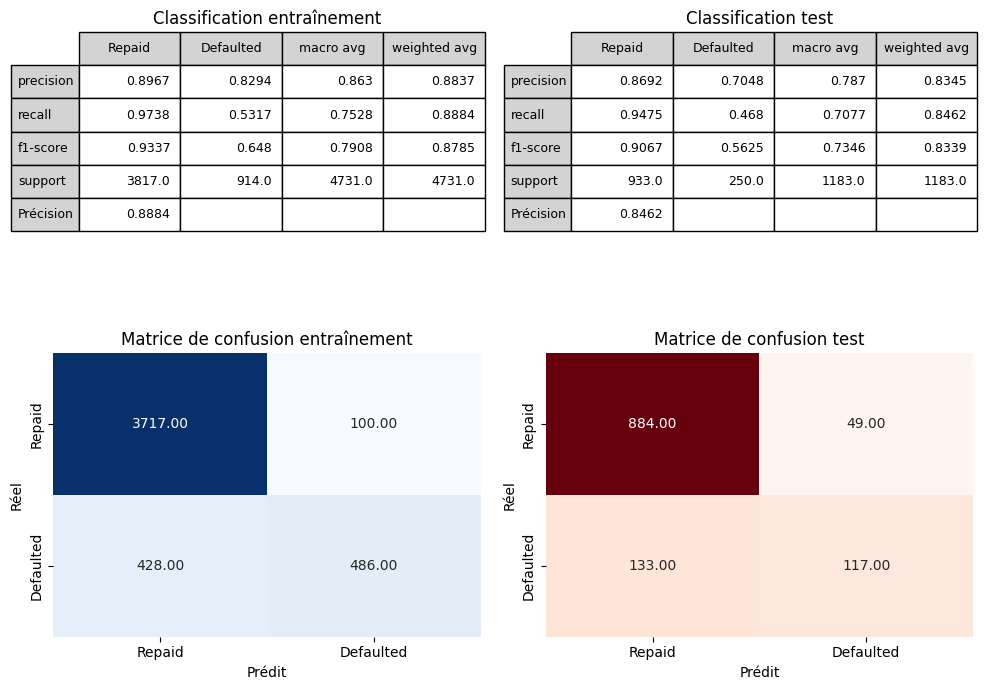

In [32]:
# Obtenir les prédictions sur les ensembles d'entraînement et de test
y_train_pred, y_test_pred, roc_auc = get_best_prediction(
    dt_model, X_train, y_train, X_test, y_test, plot=False  # Prédictions sur les données d'entraînement et de test
)

# Calculer et afficher les résultats des métriques pour les ensembles d'entraînement et de test
dt_cr_train, dt_cr_test = combined_metrics_score(
    y_train, y_train_pred, y_test, y_test_pred, labels=labels, normalize=False  # Évaluation des performances
)

# Ajouter les résultats du modèle dans le dictionnaire des modèles avec la métrique ROC AUC
models['Decision Tree'] = [dt_cr_train, dt_cr_test, {'roc_auc': roc_auc}]

**Tester l'impact du déséquilibre des classes sur les résultats avec suréchantillonnage (SMOTE)**

- Au lieu d'utiliser l'hyperparamètre `class_weight`, vérifions si l'oversampling de la classe minoritaire améliore les résultats. 
- Nous allons utiliser SMOTE pour cela.

**NOTE IMPORTANTE :**
- Nous avons observé que sur Colab, lorsque nous utilisons un GPU, SMOTE échoue parfois avec une erreur d'index. 
- Lorsqu'on utilise le CPU, cela ne semble pas se produire. Si l'erreur survient, attendre 30 secondes et réexécuter la cellule fonctionne (pas encore compris pourquoi).


In [33]:
# Appliquer SMOTE sur l'ensemble d'entraînement
smote = SMOTE(sampling_strategy='not majority')  # SMOTE suréchantillonne la classe minoritaire
X_sm = X_train.copy()  # Créer une copie de X_train pour éviter de modifier les données d'origine
# Ajouter la colonne "missing_values" pour les caractéristiques manquantes
X_sm['missing_values'] = missing_values
# Suréchantillonner avec SMOTE
X_sm, y_sm = smote.fit_resample(X_sm, y_train)

# Calculer les poids des échantillons pour SMOTE
sample_weight_sm = len(cat_features + num_features) - X_sm['missing_values']  # Poids en fonction du nombre de valeurs manquantes
X_sm.drop(columns=['missing_values'], inplace=True)  # Supprimer la colonne "missing_values"

# Vérifier la distribution des classes après SMOTE
y_sm.value_counts(normalize=True)

BAD
0    0.5
1    0.5
Name: proportion, dtype: float64

In [34]:
# Répéter le processus avec l'ensemble de données SMOTE
optimisation_params = {
    'criterion': ['gini', 'entropy'],  # Critères de division
    'max_depth': [4, 5, 6, 7],  # Profondeur maximale de l'arbre
    'min_samples_split': [2, 3, 4, 5],  # Nombre minimum d'échantillons pour diviser un noeud
    'min_samples_leaf': [1, 2, 3, 4, 5]  # Nombre minimum d'échantillons par feuille
}
# Entraîner le modèle avec les données SMOTE
dt_model_sm = fit_model(
    tree.DecisionTreeClassifier,  # Arbre de décision
    X_sm, y_sm,  # Données SMOTE
    class_weight=None,  # Ne pas utiliser de pondération de classe
    optimisation_params=optimisation_params,  # Paramètres d'optimisation
    n_jobs=n_jobs,  # Parallélisation
    sample_weight=sample_weight_sm,  # Poids des échantillons
    random_state=random_state,  # Initialisation aléatoire
    plot=False  # Ne pas afficher l'arbre
)

# Afficher les paramètres du modèle ajusté
dt_model_sm.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

Seuil optimal=0.51 G-Mean=0.75 ROC AUC=0.80


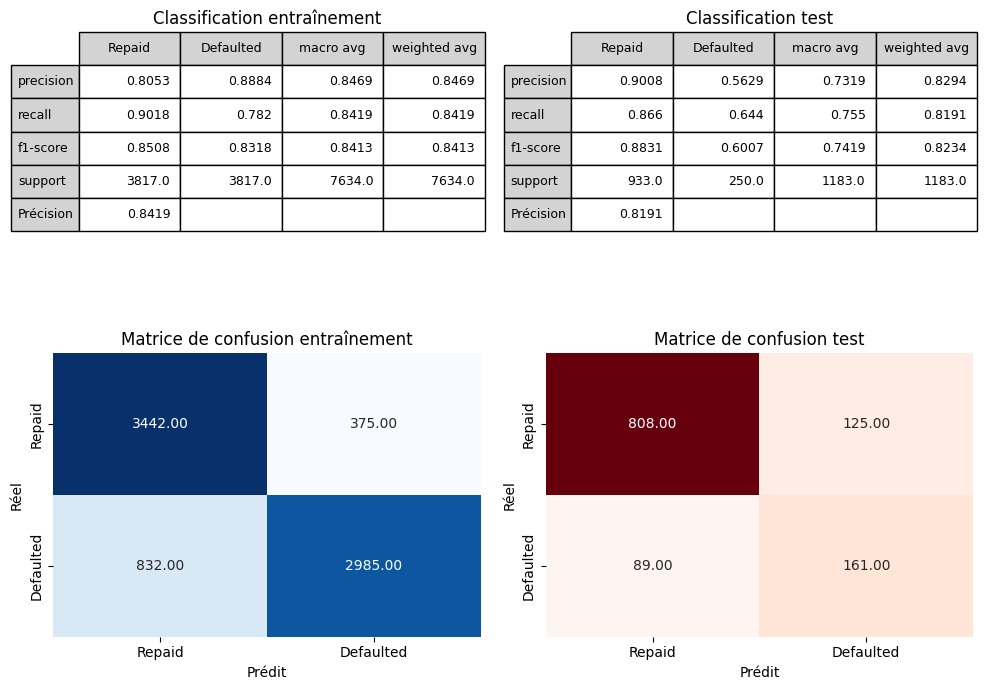

In [35]:
# Obtenir les prédictions pour les ensembles d'entraînement et de test
y_train_pred, y_test_pred, roc_auc = get_best_prediction(
    dt_model_sm, X_sm, y_sm, X_test, y_test, plot=False  # Prédictions avec SMOTE
)

# Calculer et afficher les résultats des métriques pour les ensembles d'entraînement et de test
dt_cr_train_sm, dt_cr_test_sm = combined_metrics_score(
    y_sm, y_train_pred, y_test, y_test_pred, labels=labels, normalize=False  # Évaluation des performances avec SMOTE
)

# Ajouter les résultats du modèle SMOTE dans le dictionnaire des modèles
models['Decision Tree SMOTE'] = [dt_cr_train_sm, dt_cr_test_sm, {'roc_auc': roc_auc}]

### Tester l'impact du déséquilibre des classes sur les résultats avec sous-échantillonnage (undersampling)


In [36]:
# Utilisation d'un sous-échantillonneur aléatoire (RandomUnderSampler)
rus = RandomUnderSampler(random_state=random_state)  # Initialisation du RandomUnderSampler
X_rus = X_train.copy()  # Créer une copie de X_train pour éviter de modifier les données originales
# Ajouter la colonne "missing_values" pour les caractéristiques manquantes
X_rus['missing_values'] = missing_values
# Appliquer l'undersampling pour réduire la classe majoritaire
X_rus, y_rus = rus.fit_resample(X_rus, y_train)

# Calculer les poids des échantillons pour l'undersampling
sample_weight_rus = len(cat_features + num_features) - X_rus['missing_values']  # Poids en fonction des valeurs manquantes
X_rus.drop(columns=['missing_values'], inplace=True)  # Supprimer la colonne "missing_values"

# Vérifier la distribution des classes après undersampling
y_rus.value_counts(normalize=True)

BAD
0    0.5
1    0.5
Name: proportion, dtype: float64

In [37]:
# Répéter le processus avec l'ensemble de données après undersampling
optimisation_params = {
    'criterion': ['gini', 'entropy'],  # Critères de division
    'max_depth': [4, 5, 6, 7],  # Profondeur maximale de l'arbre
    'min_samples_split': [2, 3, 4, 5],  # Nombre minimum d'échantillons pour diviser un noeud
    'min_samples_leaf': [1, 2, 3, 4, 5]  # Nombre minimum d'échantillons par feuille
}
# Entraîner le modèle avec les données sous-échantillonnées
dt_model_rus = fit_model(
    tree.DecisionTreeClassifier,  # Arbre de décision
    X_rus, y_rus,  # Données sous-échantillonnées
    class_weight=None,  # Ne pas utiliser de pondération de classe
    optimisation_params=optimisation_params,  # Paramètres d'optimisation
    n_jobs=n_jobs,  # Parallélisation
    sample_weight=sample_weight_rus,  # Poids des échantillons
    random_state=random_state,  # Initialisation aléatoire
    plot=False  # Ne pas afficher l'arbre
)

# Afficher les paramètres du modèle ajusté
dt_model_rus.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

Seuil optimal=0.62 G-Mean=0.74 ROC AUC=0.79


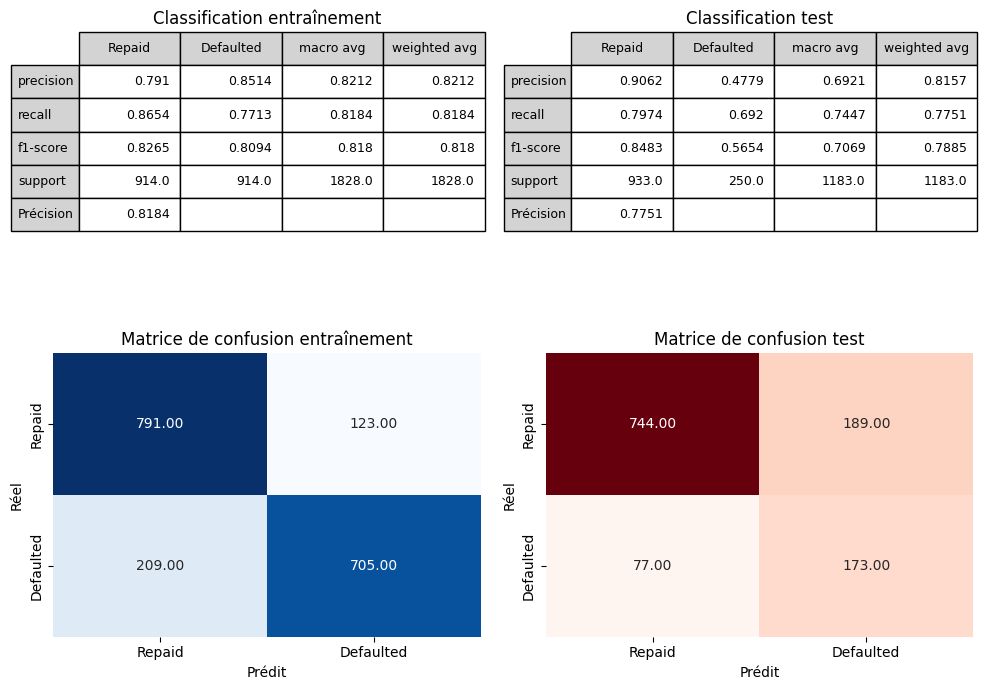

In [38]:
# Obtenir les prédictions pour les ensembles d'entraînement et de test
y_train_pred, y_test_pred, roc_auc = get_best_prediction(
    dt_model_rus, X_rus, y_rus, X_test, y_test, plot=False  # Prédictions avec l'undersampling
)

# Calculer et afficher les résultats des métriques pour les ensembles d'entraînement et de test
dt_cr_train_rus, dt_cr_test_rus = combined_metrics_score(
    y_rus, y_train_pred, y_test, y_test_pred, labels=labels, normalize=False  # Évaluation des performances avec undersampling
)

# Ajouter les résultats du modèle sous-échantillonné dans le dictionnaire des modèles
models['Decision Tree RUS'] = [dt_cr_train_rus, dt_cr_test_rus, {'roc_auc': roc_auc}]

### **Classificateur Random Forest**

Nous allons commencer avec un Random Forest non optimisé.

In [39]:
# Définir les paramètres à optimiser pour GridSearchCV
optimisation_params = None  # Aucun paramètre spécifique n'est défini pour l'optimisation dans ce cas
# Entraîner le modèle de manière simple (sans optimisation)
rf_model_simple = fit_model(
    ensemble.RandomForestClassifier,  # Utilisation du classificateur RandomForest
    X_train, y_train,  # Données d'entraînement
    class_weight="balanced",  # Pondération des classes pour gérer l'imbalance
    optimisation_params=optimisation_params,  # Pas d'optimisation des paramètres
    sample_weight=sample_weight,  # Poids des échantillons
    n_jobs=n_jobs,  # Parallélisation pour accélérer l'entraînement
    random_state=random_state,  # Initialisation aléatoire pour la reproductibilité
    plot=False  # Ne pas afficher de graphique pour cet entraînement
)

Seuil optimal=0.20 G-Mean=0.90 ROC AUC=0.96


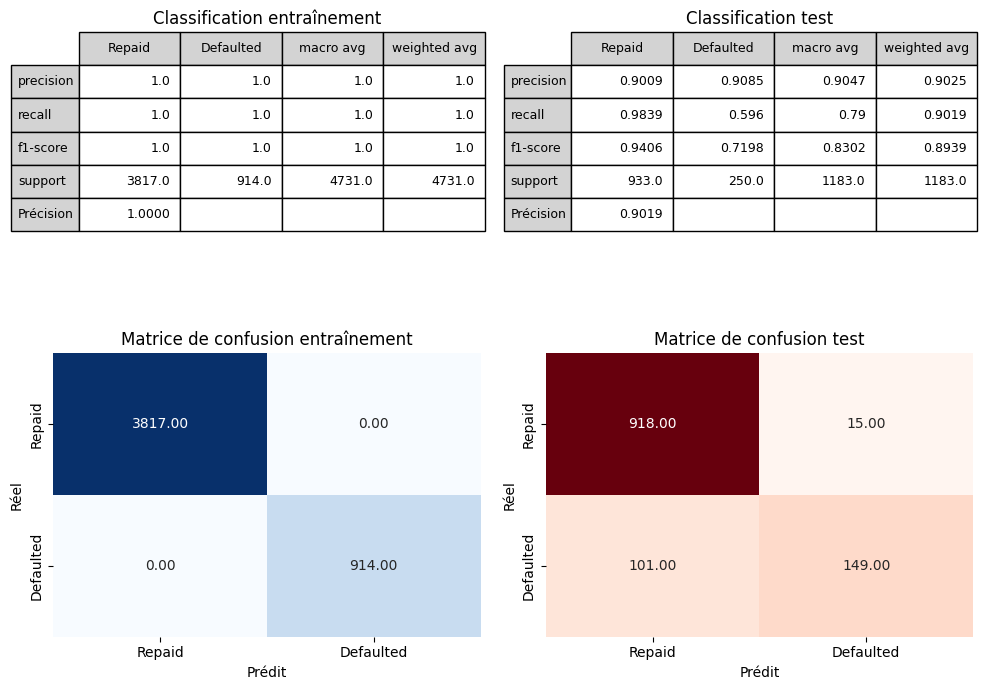

In [40]:
# Obtenir les prédictions pour les ensembles d'entraînement et de test
y_train_pred, y_test_pred, roc_auc = get_best_prediction(
    rf_model_simple, X_train, y_train, X_test, y_test, plot=False  # Prédictions avec le modèle non optimisé
)
# Calculer et afficher les résultats des métriques pour les ensembles d'entraînement et de test
rf_simple_cr_train, rf_simple_cr_test = combined_metrics_score(
    y_train, y_train_pred, y_test, y_test_pred, labels=labels, normalize=False  # Évaluation des performances
)

# Ajouter les résultats du modèle non optimisé dans le dictionnaire des modèles
models['Random Forest (not opt)'] = [rf_simple_cr_train, rf_simple_cr_test, {'roc_auc': roc_auc}]

### **Ajustement des Hyperparamètres du Classifieur Random Forest**

In [41]:
# Définir les paramètres à optimiser pour GridSearchCV
optimisation_params = {
    'criterion': ['entropy', 'gini'],  # Critères de division (entropie ou gini)
    'n_estimators': [100, 200, 500],  # Nombre d'arbres dans la forêt
    'max_depth': [5, 6, 7],  # Profondeur maximale des arbres
    'min_samples_split': [5, 10, 20]  # Nombre minimum d'échantillons pour diviser un noeud
}

# Entraîner le modèle optimal avec les paramètres définis
rf_model = fit_model(
    ensemble.RandomForestClassifier,  # Classifieur RandomForest
    X_train, y_train,  # Données d'entraînement
    class_weight="balanced",  # Pondération des classes pour traiter le déséquilibre des classes
    optimisation_params=optimisation_params,  # Paramètres d'optimisation
    sample_weight=sample_weight,  # Poids des échantillons
    n_jobs=n_jobs,  # Nombre de tâches parallèles pour l'entraînement
    random_state=random_state,  # Initialisation aléatoire
    plot=False  # Ne pas afficher le graphique du modèle
)

# Afficher les paramètres du modèle ajusté
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Seuil optimal=0.48 G-Mean=0.82 ROC AUC=0.90


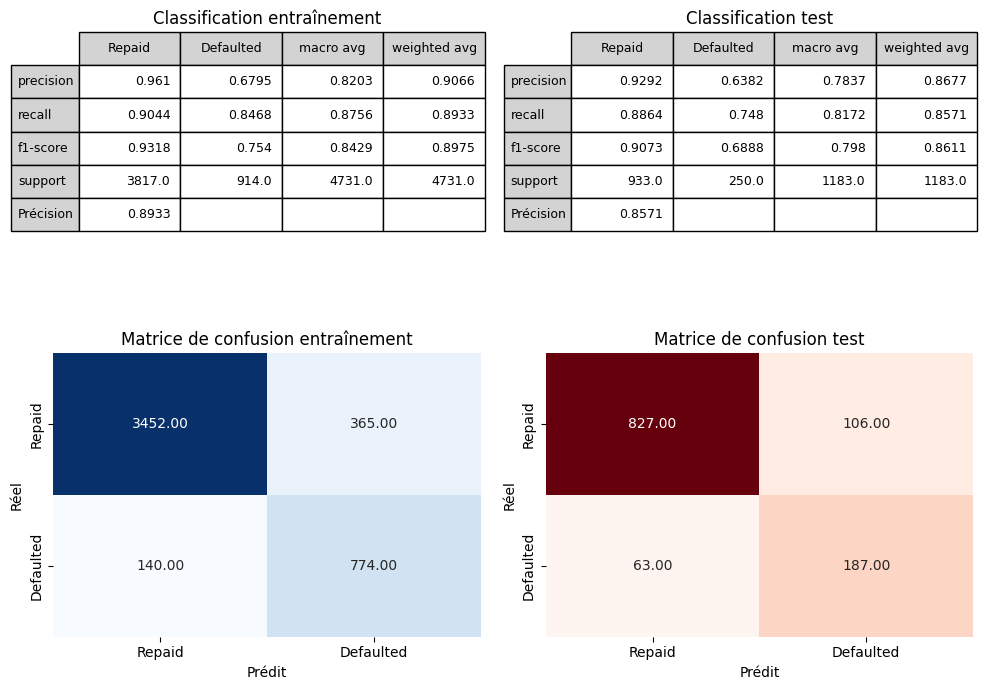

In [42]:
# Obtenir les prédictions pour les ensembles d'entraînement et de test
y_train_pred, y_test_pred, roc_auc = get_best_prediction(
    rf_model, X_train, y_train, X_test, y_test, plot=False  # Prédictions sur les ensembles d'entraînement et de test
)

# Calculer et afficher les résultats des métriques pour l'entraînement et le test
rf_cr_train, rf_cr_test = combined_metrics_score(
    y_train, y_train_pred, y_test, y_test_pred, labels=labels, normalize=False  # Évaluation des performances du modèle
)

# Ajouter les résultats du modèle Random Forest dans le dictionnaire des modèles
models['Random Forest'] = [rf_cr_train, rf_cr_test, {'roc_auc': roc_auc}]

# **Comparaison des différentes techniques et de leurs performances relatives**


In [43]:
def plot_cr(ax, df: pd.DataFrame, title="Comparaison des modèles", accuracy: int = 4, threshold: float = 0.005):
    """Affiche un rapport de classification sous forme de tableau

    Args:
        ax (plt.Axis): Un axe matplotlib
        df (pd.DataFrame): DataFrame contenant le rapport de classification
        title (str, optionnel): Titre du graphique. Par défaut "Comparaison des modèles".
        accuracy (int, optionnel): Précision d'arrondi. Par défaut 4.
        threshold (float, optionnel): Seuil pour colorier la valeur maximale par colonne. Par défaut 0.005.
    """
    
    df = df.round(accuracy)  # Arrondir les valeurs à la précision spécifiée

    ax.axis('off')  # Désactiver les axes pour afficher uniquement le tableau
    ax.set_title(title)  # Définir le titre du graphique
    table = ax.table(
        cellText=df.values,  # Remplir le tableau avec les valeurs du DataFrame
        colLabels=df.columns,  # Étiquettes des colonnes
        rowLabels=df.index.to_list(),  # Étiquettes des lignes
        rowColours=['lightgrey'] * df.shape[0],  # Couleur des lignes
        colColours=['lightgrey'] * df.shape[1],  # Couleur des colonnes
        cellColours=build_colormap(df, threshold=threshold),  # Appliquer la colorisation selon la valeur maximale
        cellLoc='center',  # Centrer le texte dans chaque cellule
        bbox=[0, .1, .8, .8]  # Définir la taille du tableau
    )
    table.auto_set_font_size(False)  # Désactiver l'ajustement automatique de la taille de la police
    table.set_fontsize(10)  # Définir la taille de la police à 10

def extract_cr(cr: dict, index: int = 0, metrics: list = ['precision', 'recall', 'accuracy'], key='weighted avg'):
    """
    Extrait le rapport de classification depuis un dictionnaire

    cr: rapport de classification
    """
    df = pd.DataFrame(columns=metrics, index=models.keys())  # Créer un DataFrame avec les métriques et les modèles

    additional_metrics = list(set(cr[list(cr.keys())[0]][index].keys()).intersection(metrics))  # Trouver les métriques supplémentaires
    metrics = [elem for elem in metrics if elem not in additional_metrics]  # Filtrer les métriques supplémentaires

    # Remplir le DataFrame avec les valeurs des métriques pour chaque modèle
    for model, cr in models.items():
        df.loc[model] = [f'{cr[index][key][m]:.4f}' for m in metrics] + [f'{cr[index][m]:.4f}' for m in additional_metrics]
    return df  # Retourner le DataFrame

def build_colormap(df: pd.DataFrame, threshold: float = 0.005) -> np.array:
    """Crée une carte de couleurs pour mettre en évidence la valeur maximale de chaque colonne (avec une certaine précision)

    Args:
        df (pd.DataFrame): DataFrame pour lequel la carte de couleurs est créée
        threshold (float, optionnel): Seuil pour mettre en évidence. Par défaut 0.005. 

    Returns:
        np.array: Carte de couleurs
    """
    highlight_color = 'gold'  # Couleur pour mettre en évidence la valeur maximale
    other_color = 'white'  # Couleur pour les autres valeurs
    
    # Fonction pour déterminer la couleur en fonction de la proximité avec la valeur maximale
    def get_color(val, max, threshold):
        if abs(float(val) - max) < threshold:
            return highlight_color  # Utiliser la couleur de mise en évidence
        else:
            return other_color  # Utiliser la couleur normale

    max_value = {col: pd.to_numeric(df[col]).max() for col in df.columns}  # Trouver la valeur maximale par colonne
    colormap = df.copy()  # Copier le DataFrame pour construire la carte de couleurs
    colormap.iloc[:, :] = other_color  # Initialiser toutes les cellules avec la couleur normale

    # Appliquer la couleur de mise en évidence pour chaque colonne
    for col in df.columns:
        colormap[col] = [get_color(val, max_value[col], threshold=threshold) for idx, val in df[col].items()]
    return colormap.to_numpy()  # Retourner la carte de couleurs sous forme de tableau numpy

def evaluate_models(models: dict, metrics: list = ['precision', 'recall', 'f1-score'], roc_auc: bool = True, threshold: float = 0.005):
    """Méthode auxiliaire pour évaluer différents modèles en affichant les principales métriques dans un tableau comparatif entre les ensembles d'entraînement et de test

    Args:
        models (dict): Résultats des modèles (matrices de confusion et scores roc_auc)
        metrics (list, optionnel): Métriques à utiliser. Par défaut ['precision', 'recall','f1-score'].
        roc_auc (bool, optionnel): Booléen indiquant si le score roc auc a été fourni. Par défaut True.
        threshold (float, optionnel): Seuil pour colorier les valeurs maximales par colonne. Par défaut 0.005.
    """
    # Extraire les métriques des résultats des modèles 
    df_train = extract_cr(models, index=0, metrics=metrics)
    df_test = extract_cr(models, index=1, metrics=metrics)
    
    # Ajouter le score roc_auc si disponible
    if roc_auc:
        df_test['roc_auc'] = [f'{models[model][2]["roc_auc"]:.4f}' for model in models.keys()]
    
    # Afficher les résultats
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    plot_cr(axes[0], df_train, title="Métriques moyennes pondérées (Entraînement)", threshold=threshold)
    plot_cr(axes[1], df_test, title="Métriques moyennes pondérées (Test)", threshold=threshold)
    plt.show()  # Afficher les graphiques
    fig.tight_layout()  # Ajuster l'agencement des graphiques

#### Comparaison de tous les modèles (en jaune, les valeurs maximales par colonne avec une précision de 0.005)


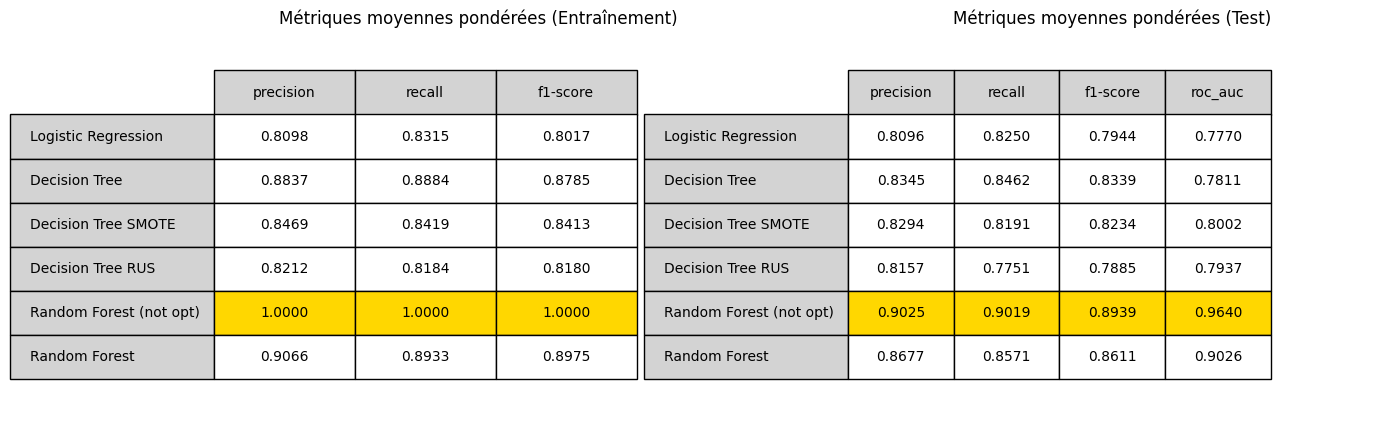

In [44]:
# Exécuter l'évaluation
evaluate_models(models, threshold=0.005)